In [51]:
import numpy as np
import matplotlib.pyplot as plt

In [152]:
# Loading data
x = np.load('x.npy') # x coordinates discretization vector

Nx = x.shape[0]
print("Num of discretization of x coordinates: ",Nx)

u0_train = np.load('u0_train_data.npy')
u0_test  = np.load('u0_test_data.npy')

Ntrain = u0_train.shape[0]
Ntest  = u0_test.shape[0]
print("Trainning data size:", Ntrain)
print("Testing data size:", Ntest)

u_train = np.load('u_train_data.npy')
u_test  = np.load('u_test_data.npy')

Num of discretization of x coordinates:  100
Trainning data size: 2000
Testing data size: 2000


In [159]:
# Plotting a few training samples
fig,axs = plt.subplots(2,2,figsize=(10,10))
axs = axs.flatten()
for s in range (4):
    axs[s].plot(x,u0_train[s],label='u(x,0)')
    axs[s].plot(x,u_train[s],label='u(x,T)')
    axs[s].legend()
# plt.savefig('result/samples.png',bbox_inches='tight')

## Score-Based Conditional Diffusion Model

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm # Use standard tqdm if notebook tqdm not available
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau # <--- 将两个调度器都导入
class SimpleScaler:
    """A simple scaler that standardizes data to zero mean and unit variance."""
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, data):
        self.mean_ = np.mean(data, axis=0)
        self.scale_ = np.std(data, axis=0)
        # Handle cases where std dev is zero to avoid division by zero
        self.scale_[self.scale_ == 0] = 1.0
        return self

    def transform(self, data):
        if self.mean_ is None or self.scale_ is None:
            raise RuntimeError("Scaler has not been fitted yet.")
        return (data - self.mean_) / self.scale_

    def inverse_transform(self, data):
        if self.mean_ is None or self.scale_ is None:
            raise RuntimeError("Scaler has not been fitted yet.")
        return data * self.scale_ + self.mean_

In [86]:
# === Device Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### DM Architechture

In [162]:
#!/usr/bin/env python
# coding: utf-8

# # ==========================================================================================
# # Generic Conditional Score-Based Diffusion Model Module
# #
# # Description:
# # This script provides a self-contained, problem-agnostic implementation of a
# # conditional score-based diffusion model. It is designed to solve inverse problems
# # by learning the conditional score function s(x_t, y, t) directly from paired data (x, y),
# # as described in "Unifying and extending Diffusion Models through PDEs for solving
# # Inverse Problems" (arXiv:2504.07437).
# # ==========================================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import numpy as np
import functools
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from livelossplot import PlotLosses
import copy
# --- 1. SDE and Time Embedding Definition (Problem-Agnostic) ---

class GaussianFourierProjection(nn.Module):
    """
    Encodes scalar time-steps into a high-dimensional feature vector
    using a set of fixed (non-trainable) random Fourier features.
    """
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, t):
        t_proj = t[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=-1)

def marginal_prob_std_fn(t, sigma):
    """
    Computes the standard deviation of p(x_t|x_0) for the VE-SDE.
    This corresponds to sigma_t in the notation p(x_t|x_0) = N(x_t; alpha_t*x_0, sigma_t^2*I).
    """
    t = torch.as_tensor(t)
    return torch.sqrt((sigma**(2 * t) - 1.) / (2. * np.log(sigma)))

def diffusion_coeff_fn(t, sigma):
    """Computes the diffusion coefficient g(t) for the VE-SDE."""
    t = torch.as_tensor(t)
    return sigma**t

# --- 2. Conditional Score Network (Problem-Agnostic) ---

class ConditionalScoreNet(nn.Module):
    """
    A time-dependent, conditional score-based model.
    It learns the score of the conditional distribution p_t(x|y), denoted as s(x, y, t).
    """
    def __init__(self, marginal_prob_std, x_dim, y_dim, hidden_depth=3, embed_dim=256):
        super().__init__()
        self.marginal_prob_std = marginal_prob_std
        
        # Time and condition embedding layers
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )
        # A simple linear layer to embed the condition y
        self.condition_embed = nn.Linear(y_dim, embed_dim)
        
        # Main network layers
        self.input_layer = nn.Linear(x_dim, embed_dim)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(embed_dim, embed_dim) for _ in range(hidden_depth)
        ])
        self.output_layer = nn.Linear(embed_dim, x_dim)
        
        self.act = nn.LeakyReLU(0.01)

    def forward(self, x, y, t):
        # 1. Generate embeddings for time and condition
        t_embedding = self.act(self.time_embed(t))
        y_embedding = self.act(self.condition_embed(y))
        
        # 2. Combine embeddings (simple addition)
        combined_embedding = t_embedding + y_embedding
        
        # 3. Process x through the network, modulated by the combined embedding
        h = self.act(self.input_layer(x))
        for layer in self.hidden_layers:
            # Add embedding and apply residual connection
            h = self.act(layer(h) + combined_embedding)
        
        out = self.output_layer(h)
        
        # 4. Scale output by the marginal standard deviation (a key part of the design)
        out = out / self.marginal_prob_std(t)[:, None]
        return out

class ConditionalConv1DScoreNet(nn.Module):
    """
    A time-dependent, conditional score-based model using a 1D U-Net architecture.
    It is specifically designed for function-like data where spatial correlation is important.
    It learns the score s(x, y, t).
    """
    def __init__(self, marginal_prob_std, x_dim, y_dim, embed_dim=256):
        super().__init__()
        self.marginal_prob_std = marginal_prob_std
        
        # Time and condition embedding layers
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )
        self.condition_embed = nn.Linear(y_dim, embed_dim)
        self.act = nn.LeakyReLU(0.01)

        # 1D U-Net Backbone
        # Encoder path
        self.conv_in = nn.Conv1d(in_channels=2, out_channels=32, kernel_size=5, padding=2) # Input channels is 2: [x_t, y]
        self.conv1 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        
        # Bottleneck layer for time embedding injection
        self.embedding_injector = nn.Linear(embed_dim, 128)

        # Decoder path with skip connections
        self.deconv1 = nn.Conv1d(128 + 64, 64, kernel_size=5, padding=2)
        self.deconv2 = nn.Conv1d(64 + 32, 32, kernel_size=5, padding=2)
        self.conv_out = nn.Conv1d(32 , 1, kernel_size=5, padding=2)
        
    def forward(self, x, y, t):
        # Reshape inputs to (Batch, Channels, Length) for Conv1d
        x = x.unsqueeze(1)
        y = y.unsqueeze(1)

        # Concatenate x_t and y as input channels
        xy_cat = torch.cat([x, y], dim=1)
        
        # Time embedding
        t_embedding = self.act(self.time_embed(t))
        
        # --- 1D U-Net Dataflow ---
        # Encoder
        h1 = self.act(self.conv_in(xy_cat)) # -> (B, 32, 100)
        h2 = self.act(self.conv1(h1))       # -> (B, 64, 100)
        h3 = self.act(self.conv2(h2))       # -> (B, 128, 100)

        # Inject time embedding at the bottleneck
        emb = self.embedding_injector(t_embedding).unsqueeze(-1)
        h3_inj = h3 + emb

        # Decoder with Skip Connections
        h_dec2_in = torch.cat([h3_inj, h2], dim=1)
        h_dec2 = self.act(self.deconv1(h_dec2_in))
        
        h_dec1_in = torch.cat([h_dec2, h1], dim=1)
        h_dec1 = self.act(self.deconv2(h_dec1_in))
        
        # The final input for the output convolution should not include the original x
        # as it's already part of the skip connection from h1
        out = self.conv_out(h_dec1) # Use h_dec1 directly
        
        # Reshape output back to (Batch, Length)
        out = out.squeeze(1)
        
        # Scale output by the marginal standard deviation
        out = out / self.marginal_prob_std(t)[:, None]
        return out

# --- 3. Loss Function (Problem-Agnostic) ---

def conditional_loss_fn(model, x, y, marginal_prob_std, eps=1e-5):
    """
    The loss function for training the conditional score model.
    Corresponds to the denoising score matching loss for p(x|y).
    with weighting to prioritize smaller noise levels.
    """
    # Sample random time steps
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    
    # Sample noise and perturb data
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None]
    
    # Get model's score prediction
    score = model(perturbed_x, y, random_t)
    
    # # Calculate loss
    loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=1))

    # Calculate the loss for each original sample.
    # loss_per_sample = torch.sum((score * std[:, None] + z)**2, dim=1)
    
    # # Define weights (using 1/std^2 here, other weights can also be tried)
    # # This weight amplifies the loss when t is small (std is small)
    # loss_weights = 1.0 / (std**2)
    
    # # Apply weights and calculate the mean.
    # loss = torch.mean(loss_weights * loss_per_sample)
    return loss

# --- 4. Training Infrastructure (Problem-Agnostic) ---

class PairedDataset(Dataset):
    """A dataset for (x, y) pairs."""
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

def train_conditional_model(
    score_model,
    # Data
    x_train_data, y_train_data,
    x_test_data, y_test_data,
    # Training params
    lr=1e-4, batch_size=32, n_epochs=100,
    # Validation params
    eval_freq=25,
    num_eval_samples=50,
    num_gen_samples=10,
    # Sampler and other components
    sampler_fn=None,
    sampler_params=None,
    x_scaler=None,
    device='cpu'
):
    """
    Trains the model for the full duration, live-plots metrics, saves the best model
    based on generation_MSE, and returns the complete metric history.
    """
    # Setup DataLoaders for both training and validation
    train_dataset = PairedDataset(x_train_data.to(device), y_train_data.to(device))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    test_dataset = PairedDataset(x_test_data.to(device), y_test_data.to(device))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    optimizer = Adam(score_model.parameters(), lr=lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs) # Using a learning rate scheduler helps with better convergence in the later stages of training.

    # Use groups to plot losses and MSE on different axes
    liveloss = PlotLosses(groups={'Log Loss': ['train_loss', 'val_loss'], 'Generation MSE': ['mse']})
    # --- History lists to store all metrics ---
    history = {
        'train_loss': [],
        'val_loss': [],
        'mse': []
    }
    best_mse = float('inf')
    best_model_state = None
    
    tqdm_epoch = tqdm(range(n_epochs), desc="Training Epochs")
    for epoch in tqdm_epoch:
        # --- Training Phase ---
        score_model.train()
        train_loss = 0.
        num_items = 0
        for x_batch, y_batch in train_loader:
            loss = conditional_loss_fn(score_model, x_batch, y_batch, score_model.marginal_prob_std)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x_batch.shape[0]
            num_items += x_batch.shape[0]
        avg_train_loss = train_loss / num_items
        history['train_loss'].append(avg_train_loss)

        # --- Validation Phase ---
        score_model.eval()
        val_loss = 0.
        num_items_val = 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                loss = conditional_loss_fn(score_model, x_batch, y_batch, score_model.marginal_prob_std)
                val_loss += loss.item() * x_batch.shape[0]
                num_items_val += x_batch.shape[0]
        avg_val_loss = val_loss / num_items_val
        history['val_loss'].append(avg_val_loss)

        logs = {'train_loss': avg_train_loss, 'val_loss': avg_val_loss}
        
        # --- Generation MSE Phase (run periodically to save time) ---
        avg_mse = np.nan # Default to NaN if not calculated this epoch
        if (epoch + 1) % eval_freq == 0:
            with torch.no_grad():
                # (The generation logic is the same as below)
                total_mse = 0.
                # Randomly select indices from the test set for evaluation
                n_test = len(x_test_data)
                eval_indices = np.random.choice(n_test, num_eval_samples, replace=False)
                for i in eval_indices:
                    y_cond_scaled = y_test_data[i].unsqueeze(0)
                    x_true_unscaled_np = x_scaler.inverse_transform(x_test_data[i].cpu().numpy().reshape(1, -1)).flatten()
                    gen_samples_scaled = sampler_fn(score_model=score_model, y_cond=y_cond_scaled, batch_size=num_gen_samples, **sampler_params)
                    gen_samples_unscaled = x_scaler.inverse_transform(gen_samples_scaled.cpu().numpy())
                    gen_mean = np.mean(gen_samples_unscaled, axis=0)
                    total_mse += np.mean((gen_mean - x_true_unscaled_np)**2)
                avg_mse = total_mse / num_eval_samples
                logs['mse'] = avg_mse

                if avg_mse < best_mse:
                    best_mse = avg_mse
                    best_model_state = copy.deepcopy(score_model.state_dict())
        
        history['mse'].append(avg_mse) # Append MSE or NaN to history
        
        # Update learning rate
        scheduler.step()

        # Update the live plot
        liveloss.update(logs)
        # Only start sending (drawing) the plot AFTER the first MSE has been calculated.
        # This ensures the 'mse' key exists in the logger's history.
        if (epoch + 1) >= eval_freq:
            liveloss.send()

    if best_model_state:
        print(f"\nLoading best model with final generation_MSE: {best_mse:.4f}")
        score_model.load_state_dict(best_model_state)

    return score_model, history
# --- 5. Sampler (Problem-Agnostic) ---

def conditional_sampler(
    score_model,
    marginal_prob_std,
    diffusion_coeff,
    y_cond,
    batch_size,
    x_dim,
    num_steps=500,
    device='cpu',
    eps=1e-3
):
    """
    Generates samples from the conditional distribution p(x|y) using the trained score model.
    Implements the reverse-time SDE sampler (Euler-Maruyama method).
    """
    score_model.eval()
    t_init = torch.ones(batch_size, device=device)
    
    # Start from pure noise
    init_x = torch.randn(batch_size, x_dim, device=device) * marginal_prob_std(t_init)[:, None]
    
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    
    x = init_x
    y_cond_batch = y_cond.repeat(batch_size, 1).to(device)

    with torch.no_grad():
        for time_step in tqdm(time_steps, desc="Conditional Sampling"):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            
            # The core change: directly use the conditional score model
            score = score_model(x, y_cond_batch, batch_time_step)
            
            # Euler-Maruyama update
            mean_x = x + (g**2)[:, None] * score * step_size
            noise = torch.randn_like(x)
            x = mean_x + g[:, None] * torch.sqrt(step_size) * noise
            
    return mean_x



### Training DM

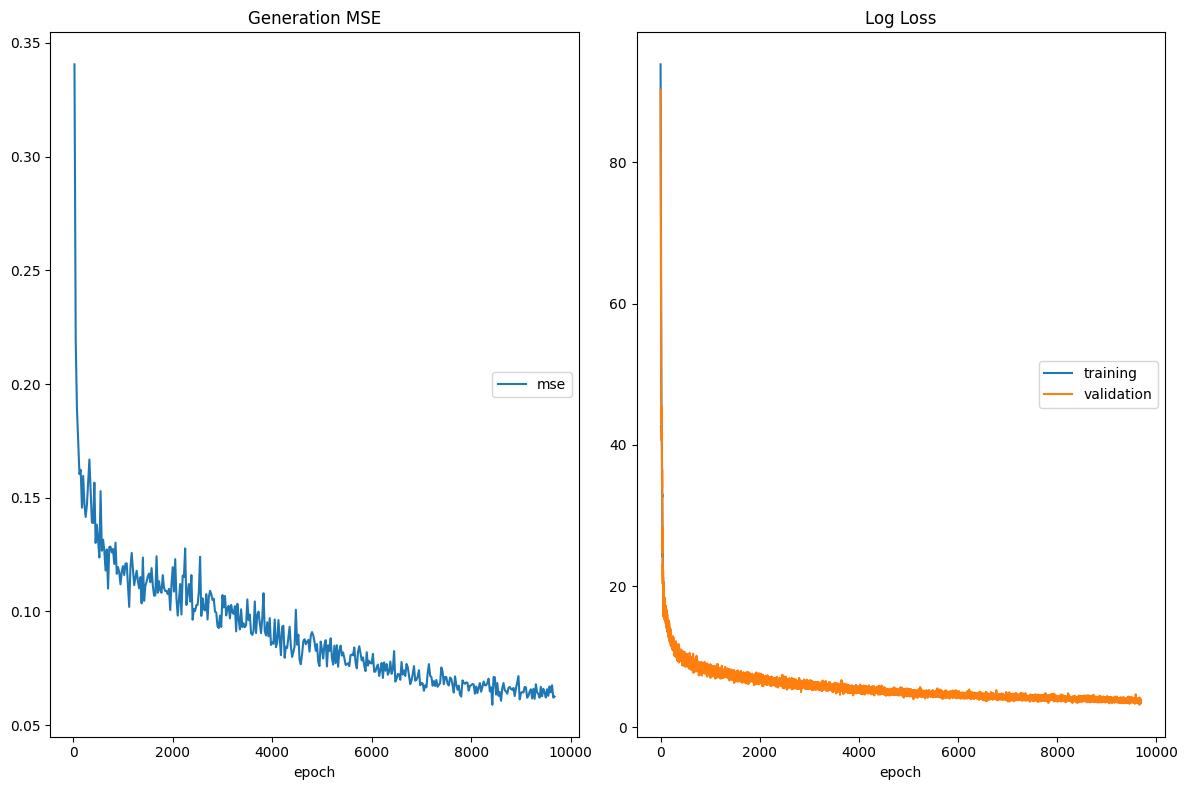

Training Epochs:  24%|██▍       | 9682/40000 [2:04:23<4:47:05,  1.76it/s]

Generation MSE
	mse              	 (min:    0.059, max:    0.341, cur:    0.063)
Log Loss
	training         	 (min:    3.566, max:   93.876, cur:    3.824)
	validation       	 (min:    3.217, max:   90.281, cur:    3.586)


In [ ]:
# ==========================================================================================
# PART 2: Application to the Provided Dataset
# ==========================================================================================

# --- Configuration Flags ---
LOAD_PRETRAINED_MODEL = False  # Set to True to skip training and load a saved model
MODEL_SAVE_PATH = 'best_score_model.pth'

# --- 2.1 Setup Environment and Load Data ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


x_coords = np.load('x.npy')
u0_train_np_raw = np.load('u0_train_data.npy')
u_train_np_raw = np.load('u_train_data.npy')
u0_test_np_raw = np.load('u0_test_data.npy')
u_test_np_raw = np.load('u_test_data.npy')

# --- 2.2 CRITICAL STEP: Filter out zero-valued ground truth samples ---
print("Filtering dataset to keep only non-zero ground truth samples...")

# Filter training data
train_non_zero_indices = [idx for idx, sample in enumerate(u0_train_np_raw) if np.max(np.abs(sample)) > 1e-6]
u0_train_full_np = u0_train_np_raw[train_non_zero_indices]
u_train_full_np = u_train_np_raw[train_non_zero_indices]

# Filter testing data
test_non_zero_indices = [idx for idx, sample in enumerate(u0_test_np_raw) if np.max(np.abs(sample)) > 1e-6]
u0_test_np = u0_test_np_raw[test_non_zero_indices]
u_test_np = u_test_np_raw[test_non_zero_indices]

print(f"Original training size: {len(u0_train_np_raw)}, Filtered training size: {len(u0_train_np)}")
print(f"Original testing size: {len(u0_test_np_raw)}, Filtered testing size: {len(u0_test_np)}")

# --- 2.3 Split the full training data into train and validation sets using NumPy ---
print("Splitting training data into training and validation sets...")
validation_split = 0.2
random_seed = 42

# Create and shuffle indices
np.random.seed(random_seed)
num_train_full = len(u0_train_full_np)
indices = np.random.permutation(num_train_full)

# Determine the split point
split_idx = int(num_train_full * (1 - validation_split))

# Split indices
train_indices, val_indices = indices[:split_idx], indices[split_idx:]

# Create the data splits using the indices
u0_train_np, u0_val_np = u0_train_full_np[train_indices], u0_train_full_np[val_indices]
u_train_np, u_val_np = u_train_full_np[train_indices], u_train_full_np[val_indices]
print(f"Final training size: {len(u0_train_np)}, Validation size: {len(u0_val_np)}, Test size: {len(u0_test_np)}")

X_DIM, Y_DIM = u0_train_np.shape[1], u_train_np.shape[1]
print(f"Problem Dimensions: X_DIM = {X_DIM}, Y_DIM = {Y_DIM}")

# --- 2.2 CRITICAL STEP: Data Normalization ---
print("Normalizing data...")
x_scaler = SimpleScaler().fit(u0_train_np) 
y_scaler = SimpleScaler().fit(u_train_np)  

x_train_tensor = torch.from_numpy(x_scaler.transform(u0_train_np)).float()
y_train_tensor = torch.from_numpy(y_scaler.transform(u_train_np)).float()
x_val_tensor = torch.from_numpy(x_scaler.transform(u0_val_np)).float()
y_val_tensor = torch.from_numpy(y_scaler.transform(u_val_np)).float()
# --- 2.3 Initialize and Train the Conditional Score Model ---

# SDE Hyperparameters
SIGMA_VE = 25.0
marginal_prob_std = functools.partial(marginal_prob_std_fn, sigma=SIGMA_VE)
diffusion_coeff = functools.partial(diffusion_coeff_fn, sigma=SIGMA_VE)

# Model Hyperparameters
EMBED_DIM, HIDDEN_DEPTH = 256, 4

# score_model = ConditionalScoreNet(
#     marginal_prob_std, X_DIM, Y_DIM, HIDDEN_DEPTH, EMBED_DIM
# ).to(device)

score_model = ConditionalConv1DScoreNet(
    marginal_prob_std, X_DIM, Y_DIM, embed_dim=EMBED_DIM
).to(device)

if LOAD_PRETRAINED_MODEL:
    print(f"Loading pre-trained model from {MODEL_SAVE_PATH}...")
    try:
        score_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
        score_model.eval() # Set model to evaluation mode
        print("Model loaded successfully.")
    except FileNotFoundError:
        print(f"Error: Model file not found at {MODEL_SAVE_PATH}. Please train the model first.")
        exit()
else:
    print(f"Training a new model with {sum(p.numel() for p in score_model.parameters())} parameters...")

# Training Hyperparameters
N_EPOCHS, BATCH_SIZE, LEARNING_RATE = 40000, 1024, 1e-4

sampler_params = {
    'marginal_prob_std': marginal_prob_std,
    'diffusion_coeff': diffusion_coeff,
    'x_dim': X_DIM,
    'num_steps': 500,
    'device': device
}

score_model, history = train_conditional_model(
    score_model,
    x_train_data=x_train_tensor, y_train_data=y_train_tensor,
    x_test_data=x_val_tensor, y_test_data=y_val_tensor, # Use validation set for model selection
    lr=LEARNING_RATE, batch_size=BATCH_SIZE, n_epochs=N_EPOCHS,
    eval_freq=25,
    sampler_fn=conditional_sampler,
    sampler_params=sampler_params,
    x_scaler=x_scaler,
    device=device
)

print("Training finished.")

# --- 2.7 Save the Best Model and Loss Curve ---
print(f"Saving the best model to {MODEL_SAVE_PATH}...")
torch.save(score_model.state_dict(), MODEL_SAVE_PATH)

fig_loss, ax1 = plt.subplots(figsize=(12, 7))

# Plotting training and validation loss on the first y-axis
ax1.plot(history['train_loss'], 'b-', label='Training Loss')
ax1.plot(history['val_loss'], 'c--', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Score Matching Loss (log scale)', color='b')
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, linestyle=':')

# Creating a second y-axis for the generation MSE
ax2 = ax1.twinx()
ax2.plot(history['mse'], 'r.-', label='Generation MSE')
ax2.set_ylabel('Generation MSE', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig_loss.suptitle('Training and Validation Metrics Over Epochs')
# Combining legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig_loss.savefig('final_loss_curve.png')
print("Metrics curve saved to 'final_loss_curve.png'.")

### Inference and visualizations

In [177]:
# = a============================================================================
# BLOCK TO REPLACE: The final inference and visualization part in the main block
# This version adds debugging prints and an optional filter for non-zero samples.
# ==============================================================================

# --- 2.8 Final, Unbiased Evaluation on the TRUE Test Set ---
print("\nPerforming final, unbiased evaluation on the held-out test set...")
NUM_TEST_SAMPLES_TO_PLOT = 4
NUM_POSTERIOR_SAMPLES = 100

fig_results, axes = plt.subplots(NUM_TEST_SAMPLES_TO_PLOT, 1, figsize=(10, 5 * NUM_TEST_SAMPLES_TO_PLOT), sharex=True)
if NUM_TEST_SAMPLES_TO_PLOT == 1: axes = [axes]

plot_indices = np.random.choice(len(u0_test_np), NUM_TEST_SAMPLES_TO_PLOT, replace=False)

for i, ax in zip(plot_indices, axes):
    # Now we use the true test data for plotting
    y_condition_np = u_test_np[i]
    x_ground_truth_np = u0_test_np[i]
    
    y_condition_scaled_np = y_scaler.transform(y_condition_np.reshape(1, -1))
    y_condition_tensor = torch.from_numpy(y_condition_scaled_np).float().to(device)
    
    posterior_samples_scaled = conditional_sampler(
        best_model, marginal_prob_std, diffusion_coeff, y_condition_tensor,
        NUM_POSTERIOR_SAMPLES, X_DIM, num_steps=2000, device=device # Use more steps for final quality
    )
    
    posterior_samples_np = x_scaler.inverse_transform(posterior_samples_scaled.cpu().numpy())
    posterior_mean = np.mean(posterior_samples_np, axis=0)
    posterior_std = np.std(posterior_samples_np, axis=0)
    
    # ... (Plotting logic remains the same)
    ax.plot(x_coords, y_condition_np, 'k:', linewidth=2, label='$u(x,T)$ (Given Condition)')
    ax.plot(x_coords, x_ground_truth_np, 'g-', linewidth=2, label='$u(x,0)$ (Ground Truth)')
    ax.plot(x_coords, posterior_mean, 'r--', linewidth=2, label='Posterior Mean Prediction')
    ax.fill_between(
        x_coords, posterior_mean - 2 * posterior_std, posterior_mean + 2 * posterior_std,
        color='r', alpha=0.2, label='Posterior Uncertainty ($\pm 2\sigma$)'
    )
    ax.set_title(f"True Test Sample (Original Index #{test_non_zero_indices[i]})")
    ax.set_ylabel("u(x)")
    ax.legend()
    ax.grid(True, linestyle='--')

axes[-1].set_xlabel("x")
plt.tight_layout()
fig_results.savefig('final_unbiased_test_results.png')
print("Inference finished. Final results plot saved to 'final_unbiased_test_results.png'.")
plt.show()


Performing final, unbiased evaluation on the held-out test set...


NameError: name 'best_model' is not defined